In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from copy import deepcopy

In [ ]:
# train_data = torchvision.datasets.MNIST(
#     './mnst_files/', train=True, download=True)

# data = train_data.data.float() / 255.0
# mean = data.mean()
# std = data.std()

In [9]:
# For reproducibility, this turns off cudnn's auto-tuner.
torch.backends.cudnn.enabled = False
torch.manual_seed(42)

# global_mean = mean.item() # MNIST train dataset mean
# global_std = std.item() # MNIST train dataset standard deviation
global_mean = 0.1307 # MNIST train dataset mean
global_std = 0.3081 # MNIST train dataset standard deviation
batch_size_train = 64
batch_size_test = 64


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((global_mean,), (global_std,)),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnst_files/', train=True, download=True,
        transform=transform),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnst_files/', train=False, download=True,
        transform=transform),
    batch_size=batch_size_test, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


/tmp/ipykernel_60927/231131970.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


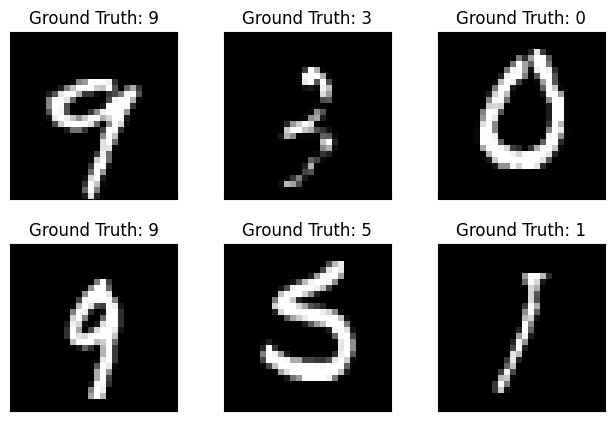

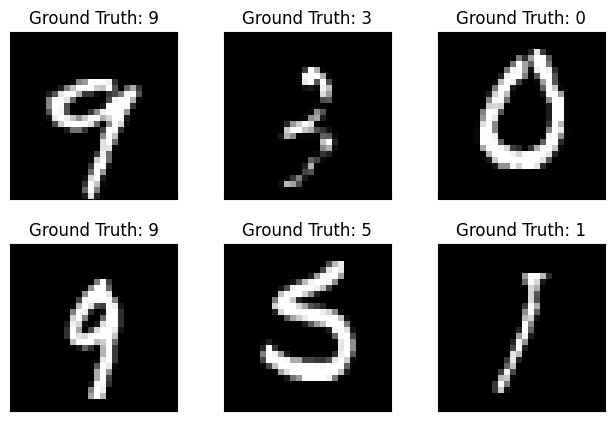

In [3]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Building the Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, input_size=1, n_classes=10, hidden_size=[50]):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=10, kernel_size=5, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.conv2_dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(320, hidden_size[0])
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size[0], n_classes)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### Define training loop

In [6]:
# Training function
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(train_loader)

    return loss_total, accuracy

# Validation function
def validate(model, data_loader, loss_fn, device):
    model.eval()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss_total += loss.item()
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(data_loader)

    return loss_total, accuracy

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    return torch.cat(predictions), accuracy


def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            y_hat = model(x)
            _, predicted = y_hat.max(1)
            predictions.append(predicted)

    return torch.cat(predictions)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model_weights = None

    def early_stop(self, validation_loss, model):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [7]:
# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training parameters
n_epochs = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Instantiate model, loss function, and optimizer
model = ConvolutionalNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    # Training
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"[{epoch+1}/{n_epochs}] Train loss: {train_loss:.4f} acc: {train_acc:.2f}%")

    # Validation
    val_loss, val_acc = validate(model, test_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'[{epoch+1}/{n_epochs}] Val loss: {val_loss:.4f} acc: {val_acc:.2f}%')

    if early_stopper.early_stop(val_loss, model):
        early_stopper.save_best_weights(model)
early_stopper.restore_best_weights(model)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

[1/100] Train loss: 0.7262 acc: 75.77%


Training Progress:   1%|          | 1/100 [00:23<38:02, 23.05s/it]

[1/100] Val loss: 0.1434 acc: 95.89%
[2/100] Train loss: 0.3209 acc: 90.24%


Training Progress:   2%|▏         | 2/100 [00:44<36:12, 22.16s/it]

[2/100] Val loss: 0.1038 acc: 96.74%
[3/100] Train loss: 0.2518 acc: 92.47%


Training Progress:   3%|▎         | 3/100 [01:06<35:25, 21.91s/it]

[3/100] Val loss: 0.0824 acc: 97.45%
[4/100] Train loss: 0.2135 acc: 93.56%


Training Progress:   4%|▍         | 4/100 [01:28<35:21, 22.10s/it]

[4/100] Val loss: 0.0704 acc: 97.69%
[5/100] Train loss: 0.1904 acc: 94.26%


Training Progress:   5%|▌         | 5/100 [01:50<34:48, 21.98s/it]

[5/100] Val loss: 0.0620 acc: 98.01%
[6/100] Train loss: 0.1749 acc: 94.77%


Training Progress:   6%|▌         | 6/100 [02:13<35:00, 22.35s/it]

[6/100] Val loss: 0.0581 acc: 98.15%
[7/100] Train loss: 0.1624 acc: 95.20%


Training Progress:   7%|▋         | 7/100 [02:36<35:12, 22.71s/it]

[7/100] Val loss: 0.0561 acc: 98.28%
[8/100] Train loss: 0.1518 acc: 95.56%


Training Progress:   8%|▊         | 8/100 [03:00<35:23, 23.08s/it]

[8/100] Val loss: 0.0512 acc: 98.47%
[9/100] Train loss: 0.1417 acc: 95.76%


Training Progress:   9%|▉         | 9/100 [03:23<34:50, 22.97s/it]

[9/100] Val loss: 0.0484 acc: 98.47%
[10/100] Train loss: 0.1348 acc: 95.94%


Training Progress:  10%|█         | 10/100 [03:46<34:21, 22.91s/it]

[10/100] Val loss: 0.0431 acc: 98.72%
[11/100] Train loss: 0.1298 acc: 96.17%


Training Progress:  11%|█         | 11/100 [04:09<33:59, 22.91s/it]

[11/100] Val loss: 0.0442 acc: 98.64%
[12/100] Train loss: 0.1205 acc: 96.52%


Training Progress:  12%|█▏        | 12/100 [04:32<33:34, 22.89s/it]

[12/100] Val loss: 0.0410 acc: 98.71%
[13/100] Train loss: 0.1166 acc: 96.58%


Training Progress:  13%|█▎        | 13/100 [04:56<33:48, 23.32s/it]

[13/100] Val loss: 0.0402 acc: 98.79%
[14/100] Train loss: 0.1127 acc: 96.61%


Training Progress:  14%|█▍        | 14/100 [05:19<33:14, 23.20s/it]

[14/100] Val loss: 0.0388 acc: 98.88%
[15/100] Train loss: 0.1104 acc: 96.75%


Training Progress:  15%|█▌        | 15/100 [05:42<32:48, 23.16s/it]

[15/100] Val loss: 0.0439 acc: 98.78%
[16/100] Train loss: 0.1075 acc: 96.78%


Training Progress:  16%|█▌        | 16/100 [06:05<32:28, 23.19s/it]

[16/100] Val loss: 0.0405 acc: 98.78%
[17/100] Train loss: 0.1045 acc: 96.91%


Training Progress:  17%|█▋        | 17/100 [06:28<31:58, 23.12s/it]

[17/100] Val loss: 0.0397 acc: 98.86%
[18/100] Train loss: 0.0993 acc: 97.00%


Training Progress:  18%|█▊        | 18/100 [06:52<31:47, 23.26s/it]

[18/100] Val loss: 0.0404 acc: 98.76%
[19/100] Train loss: 0.0996 acc: 97.04%


Training Progress:  19%|█▉        | 19/100 [07:15<31:28, 23.31s/it]

[19/100] Val loss: 0.0367 acc: 98.87%
[20/100] Train loss: 0.0989 acc: 97.03%


Training Progress:  20%|██        | 20/100 [07:39<31:12, 23.40s/it]

[20/100] Val loss: 0.0358 acc: 99.00%
[21/100] Train loss: 0.0947 acc: 97.20%


Training Progress:  21%|██        | 21/100 [08:02<30:43, 23.34s/it]

[21/100] Val loss: 0.0354 acc: 98.93%
[22/100] Train loss: 0.0927 acc: 97.26%


Training Progress:  22%|██▏       | 22/100 [08:25<30:06, 23.16s/it]

[22/100] Val loss: 0.0369 acc: 98.94%
[23/100] Train loss: 0.0915 acc: 97.24%


Training Progress:  23%|██▎       | 23/100 [08:48<29:40, 23.12s/it]

[23/100] Val loss: 0.0359 acc: 98.99%
[24/100] Train loss: 0.0897 acc: 97.28%


Training Progress:  24%|██▍       | 24/100 [09:11<29:18, 23.13s/it]

[24/100] Val loss: 0.0355 acc: 98.97%
[25/100] Train loss: 0.0870 acc: 97.39%


Training Progress:  25%|██▌       | 25/100 [09:34<28:53, 23.12s/it]

[25/100] Val loss: 0.0365 acc: 98.96%
[26/100] Train loss: 0.0878 acc: 97.34%


Training Progress:  26%|██▌       | 26/100 [09:58<28:55, 23.46s/it]

[26/100] Val loss: 0.0337 acc: 99.02%
[27/100] Train loss: 0.0811 acc: 97.58%


Training Progress:  27%|██▋       | 27/100 [10:21<28:24, 23.35s/it]

[27/100] Val loss: 0.0347 acc: 99.05%
[28/100] Train loss: 0.0812 acc: 97.58%


Training Progress:  28%|██▊       | 28/100 [10:45<28:08, 23.46s/it]

[28/100] Val loss: 0.0361 acc: 99.00%
[29/100] Train loss: 0.0818 acc: 97.56%


Training Progress:  29%|██▉       | 29/100 [11:09<28:05, 23.74s/it]

[29/100] Val loss: 0.0356 acc: 98.98%
[30/100] Train loss: 0.0803 acc: 97.55%


Training Progress:  30%|███       | 30/100 [11:33<27:48, 23.83s/it]

[30/100] Val loss: 0.0330 acc: 98.98%
[31/100] Train loss: 0.0787 acc: 97.61%


Training Progress:  31%|███       | 31/100 [11:57<27:17, 23.74s/it]

[31/100] Val loss: 0.0309 acc: 99.01%
[32/100] Train loss: 0.0784 acc: 97.75%


Training Progress:  32%|███▏      | 32/100 [12:21<26:57, 23.79s/it]

[32/100] Val loss: 0.0348 acc: 98.97%
[33/100] Train loss: 0.0782 acc: 97.67%


Training Progress:  33%|███▎      | 33/100 [12:44<26:30, 23.75s/it]

[33/100] Val loss: 0.0340 acc: 99.01%


Training Progress:  33%|███▎      | 33/100 [12:49<26:02, 23.31s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(network.state_dict(), '/results/model.pth')
torch.save(optimizer.state_dict(), '/results/optimizer.pth')

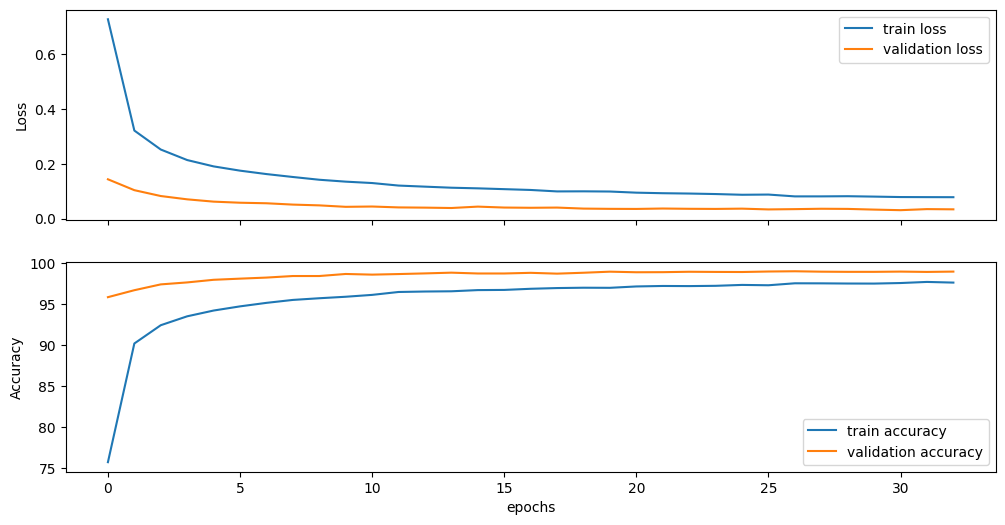

In [13]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

# Copy the tensors from GPU to CPU
train_loss_cpu = torch.Tensor(train_losses).cpu().tolist()
val_loss_cpu = torch.Tensor(val_losses).cpu().tolist()
train_acc_cpu = torch.Tensor(train_accuracies).cpu().tolist()
val_acc_cpu = torch.Tensor(val_accuracies).cpu().tolist()

ax1.plot(train_loss_cpu, label="train loss")
ax1.plot(val_loss_cpu, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_acc_cpu, label="train accuracy")
ax2.plot(val_acc_cpu, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()